In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

## Ex. Calibrate Scale

The calibration image is a photo of a black and white grating. THis image is brought into imageJ where you can take the average along the horizontal to get a "Square wave". This grating has been made with know widths, and so we can use it to convert pixels to SI units.

[32.1598 32.2925 32.5363 ... 32.8029 32.8942 32.8164]


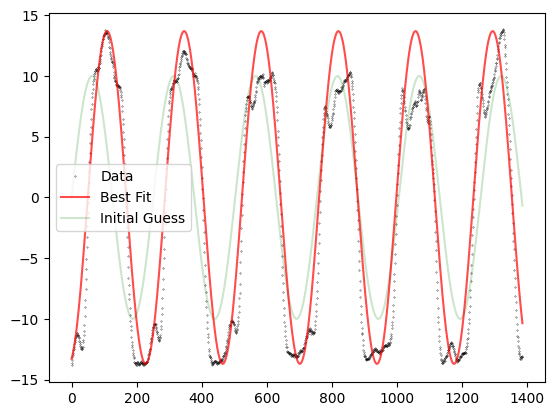

0.02652500448313248
For a 100.0um gratting, we found 2.65 +/- 0.00 um per pixel


In [ ]:
calibration_file = 'data/example_calibration.txt'
x, y = np.genfromtxt(calibration_file,delimiter='\t', skip_header = 1, unpack=True)

ymax = np.max(y)
ymin = np.min(y)
print(y)
y -= (ymax - ymin)/2 + ymin  # center the data on y=0
p0=[10, 0.025, 0]

# Easier to fit a sin wave than a square wave
def fit_function(x, A, w, phi):
    return A*np.sin(w*x + phi)
popt, pcov = curve_fit(fit_function, x, y, p0=p0)
error = np.sqrt(np.diag(pcov))

plt.plot(x,y,"k.",markersize=0.5, label='Data')
plt.plot(x, fit_function(x, *popt),"r-",markersize=0.5, alpha=0.7, label='Best Fit')
plt.plot(x, fit_function(x, *p0),"g-",markersize=0.5, alpha=0.2, zorder=0, label='Initial Guess')
plt.legend()
plt.show()

w_opt = popt[1]
w_err = error[1]
# This is the frequency in pixels. Ie the number of full waves per pixel. We want to inver this!
waves_per_px = w_opt
print(w_opt)

# Assume
um_per_wave = 100  # say um
um_per_px = waves_per_px * um_per_wave
um_per_px_err = w_err*um_per_wave

# We get
print(f'For a {um_per_wave:.1f}um gratting, we found {um_per_px:.2f} +/- {um_per_px_err:.2f} um per pixel')

def convert_px_to_um(x):
    return x*um_per_px

# Example Analysis for MM

## Ex. Load Data

Reading up to line 302, skipping last 71 lines.


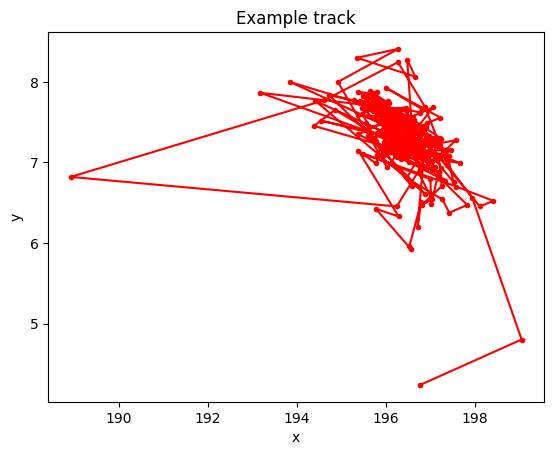

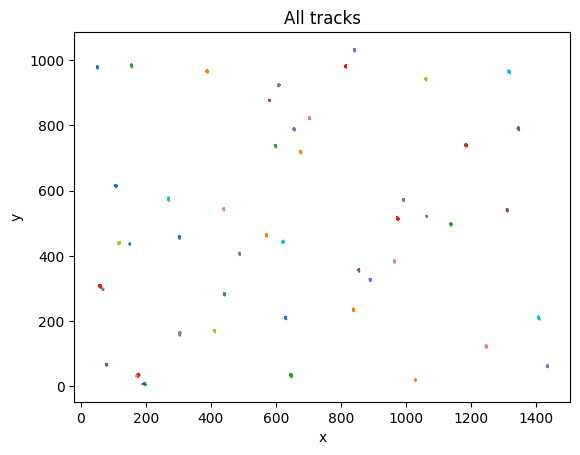

In [ ]:
def load_from_mtrack(filename, skip_footer=2):
    # get number of data points, found on line 2 in format "Track 1 of N"
    # Edited version of example file
    with open(filename, 'r') as f:
        f.readline()
        line = f.readline()
        n_tracks = int(line.split(' to ')[-1])
        # get total number of lines
        total_lines =len(f.readlines())
    max_length = total_lines - n_tracks
    print(f'Reading up to line {max_length}, skipping last {n_tracks} lines.')

    my_data = np.genfromtxt(filename, delimiter='\t', skip_header=2, max_rows=max_length-2)
    # skip_footer value can be increased if you have erroneous text at the end of your data file.
    # Remove indexer, summary box and Flags column
    A=np.zeros(my_data.shape[1]//3+1)
    for i in range (my_data.shape[1]//3+1):
        A[i]=3*i
    A = A.astype(int)
    new_data = np.delete(my_data, A, axis=1)

    # This can now be seperated into new dimension for each Xn, Yn
    # LEts make it (track, coordinate, data)
    n_samples = new_data.shape[0]
    shaped_data = new_data.reshape(n_samples, n_tracks, 2).transpose(1, 2, 0)

    # Sorting the data for easier analysis.  Meaning that __NaN__ are sorted to the end of the list.
    mask = np.isnan(new_data)
    return shaped_data

def clean_nans_from_data(data):
    # Made with chatGPT and stack overflow
    trackNum, _, N = data.shape
    cleaned_tracks = {}
    for i in range(trackNum):
        # Get x and y data for this track 
        x, y = data[i] # Find the last non-NaN index (same for x and y) 
        valid_indices = ~np.isnan(x) # Boolean mask where x is NOT NaN 
        if np.any(valid_indices): # Ensure there are valid values 
            valid_N = np.max(np.where(valid_indices)) + 1 # Get last valid index +1 
            cleaned_tracks[i] = data[i, :, :valid_N] # Trim (2, valid_N) 
    return cleaned_tracks # Return cleaned_tracks as dict as they may be different lengths

# Load data
filename = 'data/yeast_sample_feb25.txt'
data = load_from_mtrack(filename)
clean_data = clean_nans_from_data(data)
# Data is a array of shape (n_samples, n_tracks, 2)
# There are NaNs at the end of each track which are there to maintain proper shape
# Important:
# To use get a track, you do "x, y = clean_data[i]" where i is an intiger
# ex.

# Plot one track
x0, y0 = clean_data[0]
plt.plot(x0, y0, 'r.-')
plt.title("Example track")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Use loop to plot all tracks
for trackNumber in range(len(clean_data)):
    x, y = clean_data[trackNumber]
    plt.plot(x, y, '-')
plt.title("All tracks")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Calculate:
- Mean (use np.mean)
- Variance (use np.variance)
- Diffusion coefficient (See page 8 of the second reading)

The better way to do this which you should do with my help, is fit the histogram of position data with a gaussian as defines in Eqn 16 of the second reading (page 9).

In [ ]:

# Plot one track
x, y = clean_data[0]

# Mean
mean_x = np.mean(x)
mean_y = np.mean(y)

# Variance
var_x = np.var(x)
var_y = np.var(y)

print(f'Means:\tx={mean_x}\ty={mean_y}')
print(f'Vars:\tx={var_x}\ty={var_y}')

# In page 8 of the second reading resource:
# variance = 6*D*t
delta_t = 1  # Unknown, this is set within imageJ and is not saved to data
D_x = var_x/(6*delta_t)
D_y = var_y/(6*delta_t)
print(f'DiffCoef:\tx={D_x}\ty={D_y}')


Means:	x=196.33953813333335	y=7.307484619333333
Vars:	x=0.6343627682345153	y=0.19135090123168152
DiffCoef:	x=0.10572712803908589	y=0.03189181687194692


## Ex. Scatter with Histogram

Reading up to line 302, skipping last 71 lines.


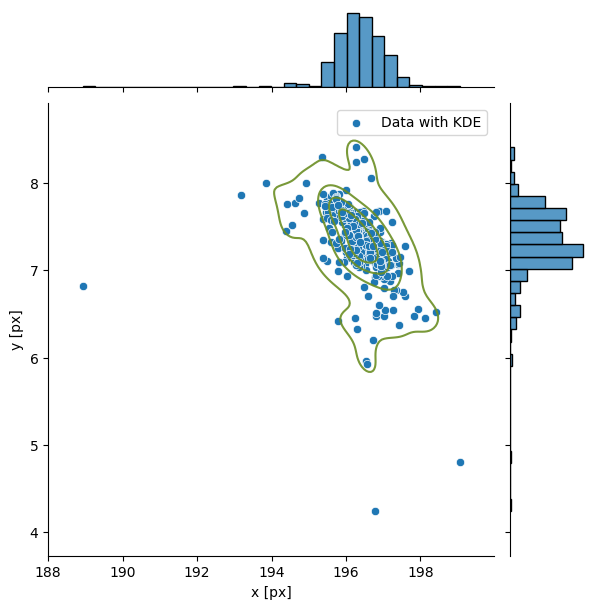

In [29]:
# Load data
filename = 'data/yeast_sample_feb25.txt'
data = load_from_mtrack(filename)
clean_data = clean_nans_from_data(data)

# Chose track & bin settings
track_number = 0
nbins = 30
contour_levels=5

x, y = clean_data[track_number]
g = sb.jointplot(x=x, y=y, marginal_kws=dict(bins=nbins, fill=True), label='Data with KDE')
g.plot_joint(sns.kdeplot, zorder=10, levels=contour_levels, alpha=0.9, color='olivedrab')
g.set_axis_labels('x [px]', 'y [px]')
plt.legend()


## Ex. Fit a Gaussian to the histogram

Reading up to line 302, skipping last 71 lines.


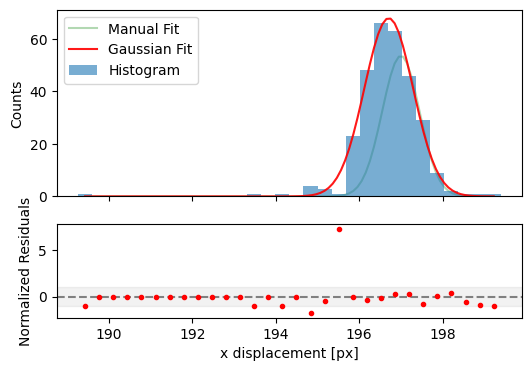

In [ ]:
# Lets do 1D first -> X
# Load data
filename = 'data/yeast_sample_feb25.txt'
data = load_from_mtrack(filename)
clean_data = clean_nans_from_data(data)

# Chose track & bin settings
track_number = 0
nbins = 30

# Load data and histogram  #######################################################################
x, y = clean_data[track_number]
counts, bins = np.histogram(x, bins=nbins, density=False)
count_error = np.sqrt(counts)

# Turn bin edges to centers:
bin_centers = bins[1:] + np.diff(bins)[0]/2  # subtract half of the bin spacing to shift left

# Plot           ##################################################################################
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(6,4), sharex=True,height_ratios=[2, 1])
ax_top.bar(bin_centers, counts, alpha=0.6, width=np.diff(bins)[0], label='Histogram')
ax_top.set_ylabel('Counts')

# Do the fit     ##################################################################################
def fit_function(x, A, tD, mean_x):
    coef = 1/np.sqrt(4*np.pi*tD)
    return A*coef*np.exp(-((x - mean_x)**2)/(4*tD))
p0 = [60, 0.100, 197]
popt, pcov = curve_fit(fit_function, bin_centers, counts, p0=p0)
errors = np.sqrt(np.diag(pcov))

# Plot the fit   ##################################################################################
model_x = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
ax_top.plot(model_x, fit_function(model_x, *p0), label='Manual Fit', color='green', alpha=0.3, zorder=0)
ax_top.plot(model_x, fit_function(model_x, *popt), label='Gaussian Fit', color='red', alpha=0.9)
ax_top.legend()

# Make residuals ##################################################################################
residuals = fit_function(bin_centers, *popt) - counts
norm_resid = residuals/count_error
norm_resid = np.where(norm_resid == np.inf, 0, norm_resid)  # Set any infinities to zero

ax_bottom.plot(bin_centers, norm_resid, 'r.')
ax_bottom.axhline(0, color='grey', linestyle='dashed', zorder=1)
ax_bottom.axhspan(-1, 1, color='grey', alpha=0.1, zorder=0)
ax_bottom.set_ylabel('Normalized Residuals')
ax_bottom.set_xlabel('x displacement [px]')

plt.show()